In [9]:
from qutip import *

import numpy as np

import matplotlib.pyplot as plt

In [3]:
def Hxyz(N, Jx, Jy, Jz, b, periodic=False):
    """Generates an XYZ spin chain Hamiltonian with N spins"""
    J_list = [Jx, Jy, Jz]
    sigma_list = [sigmax(), sigmay(), sigmaz()]
    if N <= 1:
        return qeye(2**N)
    Ham = 0
    for i in range(N-1):
        for j in range(3):
            spin_list = [sigma_list[j] if k == i or k == i+1 else qeye(2) for k in range(N)]
            Ham += J_list[j]*tensor(spin_list)
    for i in range(N):
        spin_list = [sigmaz() if k == i else qeye(2) for k in range(N)]
        Ham += b*tensor(spin_list)
    if periodic:
        for j in range(3):
            spin_list = [sigma_list[j] if k == 0 or k == N-1 else qeye(2) for k in range(N)]
            Ham += J_list[j]*tensor(spin_list)
    return Ham

In [4]:
def collision_model_dynamics(num_spins, num_col, rho_S_0, rho_A, expec_list_S, H_S, H_int, t, gamma, dt):
    """Simulates collision model dynamics and returns expectation values at each step"""
    state = tensor(rho_S_0, rho_A)
    expec_list_SA = [tensor(ex, qeye(2)) for ex in expec_list_S]
    H_col = tensor(H_S, qeye(2)) + H_int
    free_steps = np.ceil(np.random.exponential(gamma/dt, size = num_col))
    col_step = int(np.ceil(t/dt))
    total_col = np.sum(free_steps) + col_step*num_col
    num_expec = len(expec_list_S)
    expec_out = np.zeros((int(total_col), num_expec))
    #expec_out = []
    times_col = np.linspace(dt, col_step*dt, col_step)
    expec_loc = 0
    trace_list = [i for i in range(num_spins)]
    opts = Options()
    opts.store_final_state = True
    


    for i in range(num_col):
        res_col = mesolve(H_col, state, times_col, [], expec_list_SA, options = opts)
        for j in range(col_step):
            for k in range(num_expec):
                expec_out[expec_loc][k] = res_col.expect[k][j]
            expec_loc += 1
        
        times_free = np.linspace(dt, free_steps[i]*dt, int(free_steps[i]))
        rho_S = res_col.final_state.ptrace(trace_list)
        res_free = mesolve(H_S, rho_S, times_free, [], expec_list_S, options = opts)
        for j in range(int(free_steps[i])):
            for k in range(num_expec):
                expec_out[expec_loc][k] = res_free.expect[k][j]
            expec_loc += 1
        
        state = tensor(res_free.final_state, rho_A)
    
    return expec_out

In [25]:
# Set all the relevant parameters
bfield = 0.5
J = 1.
gamma = 1.
Delta = 0.

num_collision = 1200
collision_duration = 0.5
timestep = 0.01

num_spins = 4

In [26]:
# Generate initial states
np.random.seed(10) #10 best for 4 spins
psi_0 = tensor([rand_ket_haar(2) for _ in range(num_spins)])
rho_S_0 = psi_0 * psi_0.dag()

beta = 2. #temperature
g_prob = 0.5*(1+np.tanh(beta))
rho_A = g_prob * (basis(2,1) * basis(2,1).dag()) + (1-g_prob) * (basis(2,0) * basis(2,0).dag())

# Expectation values to calculate
expec_list_S = [tensor([sigmax() if k == i else qeye(2) for k in range(num_spins)]) 
              for i in range(num_spins)] + [tensor([sigmay() if k == i else qeye(2) for k in range(num_spins)]) 
              for i in range(num_spins)]

# System and interaction Hamiltonians
H_S = -Hxyz(num_spins, J, J*gamma, J*Delta, bfield, periodic=True)
H_SA = 0.5*(tensor(sigmax(), *[qeye(2) for _ in range(num_spins - 1)], sigmax()) 
          + tensor(sigmay(), *[qeye(2) for _ in range(num_spins - 1)], sigmay()))

In [27]:
expectations = collision_model_dynamics(num_spins, num_collision, rho_S_0, rho_A, expec_list_S, 
                               H_S, H_SA, collision_duration, gamma, timestep)

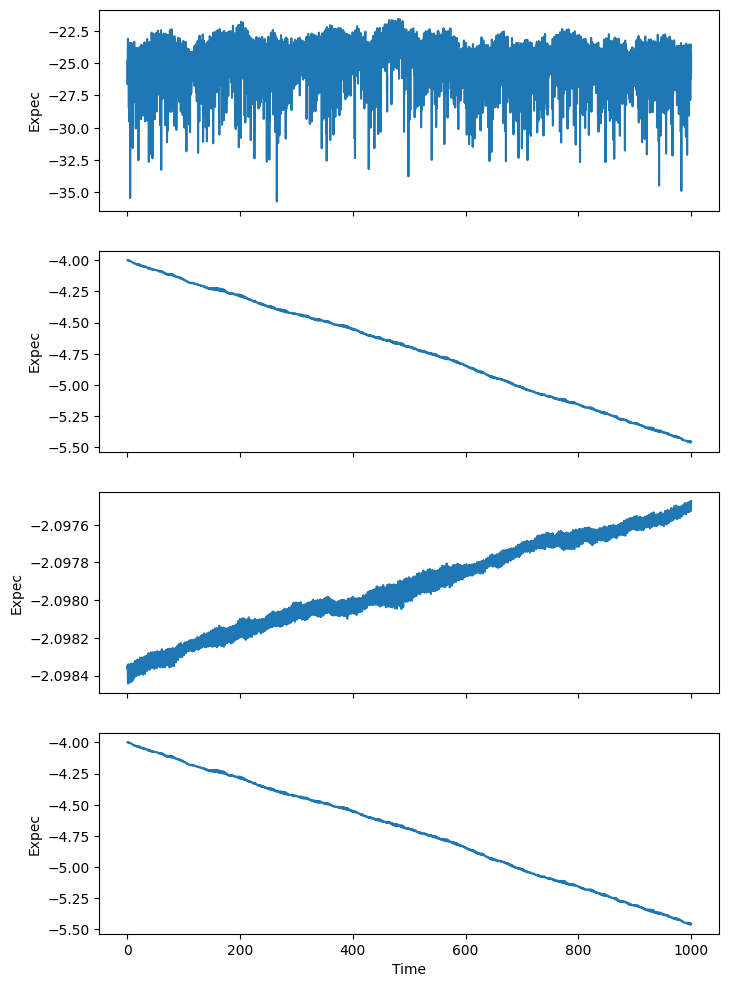

In [32]:
spaced_expec = expectations[-int(1000/timestep):, :]

time_axis = np.arange(spaced_expec.shape[0]) * timestep

fig, axs = plt.subplots(num_spins, 1, figsize=(8, 12), sharex=True)

for i in range(num_spins):
    #axs[i].plot(time_axis, spaced_expec[:, i]**2, time_axis, spaced_expec[:, i + num_spins]**2)
    axs[i].plot(time_axis, np.log(spaced_expec[:, i]**2 + spaced_expec[:, i + num_spins]**2))
    axs[i].set_ylabel('Expec')

axs[num_spins-1].set_xlabel('Time')


plt.show()

[-1.44731939e-03 -3.99566173e+00]
[0.11920292 0.02659699 0.01798621 0.00669285 0.00091105]


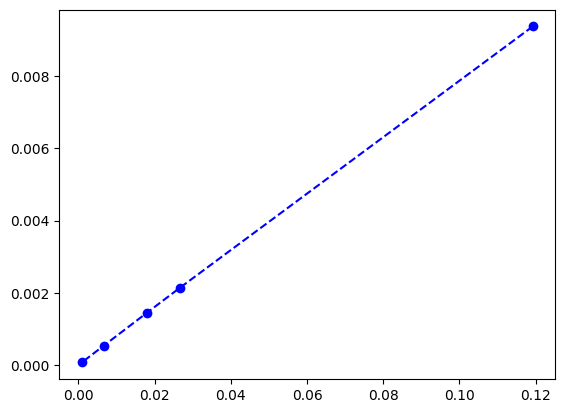

In [33]:
coef = np.polyfit(time_axis, np.log(spaced_expec[:, i]**2 + spaced_expec[:, i + num_spins]**2),1)
print(coef)

# Exponential fits for various values of beta
fit_vals = np.array([-9.37262609e-03, -2.13596356e-03, -1.44731939e-03, -5.39298752e-04, -7.31342883e-05])
beta_vals = [1., 1.8, 2., 2.5, 3.5]
e_vals = 1-0.5*(1+np.tanh(beta_vals))
print(e_vals)

plt.figure()
plt.plot(e_vals, -fit_vals, '--bo')

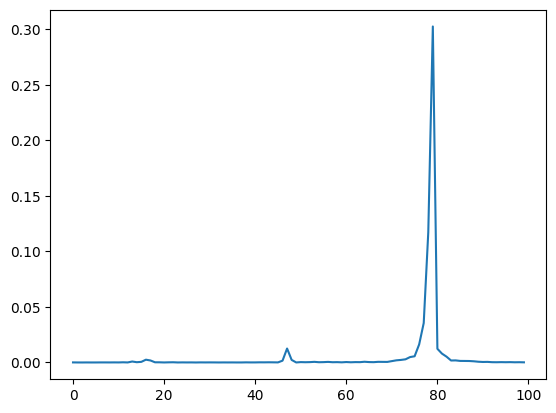

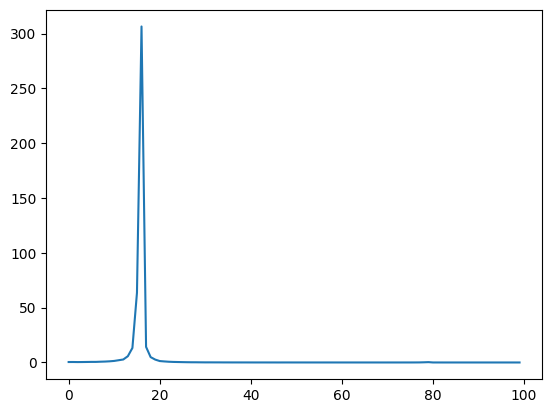

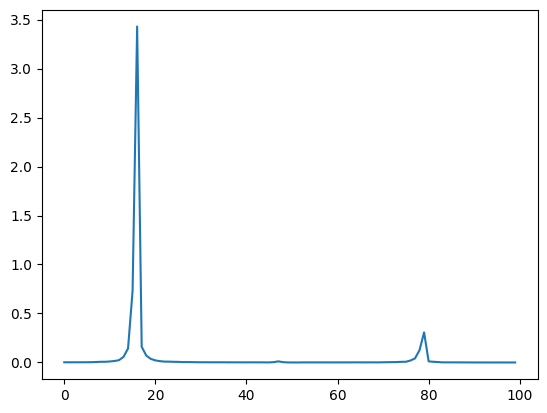

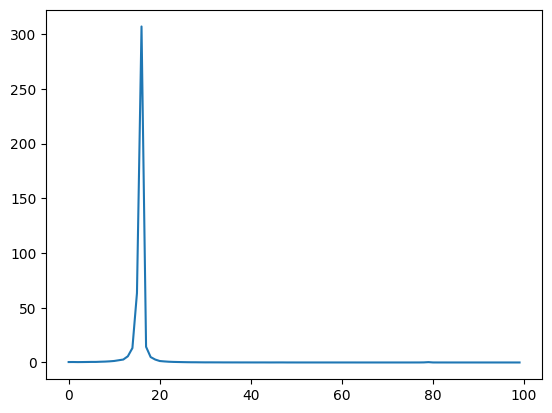

In [314]:
spaced_expec = expectations[-int(100/timestep):, :]

ps1 = np.abs(np.fft.fft(spaced_expec[:, 0]))**2
ps2 = np.abs(np.fft.fft(spaced_expec[:, 1]))**2
ps3 = np.abs(np.fft.fft(spaced_expec[:, 2]))**2
ps4 = np.abs(np.fft.fft(spaced_expec[:, 3]))**2

plt.figure()
plt.plot(ps1[:100]) # Shows the peak at 0 Hz
plt.figure()
plt.plot(ps2[:100])
plt.figure()
plt.plot(ps3[:100])
plt.figure()
plt.plot(ps4[:100])